## 제주 빅데이터 경진대회
#### 이민혁
### Problem : 2020.04, 2020.07 기간 내 지역, 업종 별 월간 총 사용 금액 예측 
- 2019.01 ~ 2020.03 기간 내 카드 데이터, 201901-202003.csv (2.07 GB)
- 2020.04 기간 내 카드 데이터 (7/28 공개), 202004.csv (116 MB)
- 제출 양식, submission.csv (64 KB)


## 1. 라이브러리, 데이터 불러오기

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('201901-202003.csv')
data2 = pd.read_csv('202004.csv')
df = pd.concat([data, data2])

In [4]:
df

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM HOM_CCG_NM  \
0          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
1          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
2          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
3          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
4          201901           강원         강릉시  건강보조식품 소매업          강원        강릉시   
...           ...          ...         ...         ...         ...        ...   
1350317    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350318    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350319    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350320    202004           충북         충주시    휴양콘도 운영업          충북        충주시   
1350321    202004           충북         충주시    휴양콘도 운영업          충북        충주시   

         AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0        20s            1    1          4   311200    4  
1        30s            1    2          7  1374500    8  
2        30s            2    2          6   818700    6  
3        40s            1    3          4  1717000    5  
4        40s            1    4          3  1047300    3  
...      ...          ...  ...        ...      ...  ...  
1350317  20s            1    1          5    77000    5  
1350318  30s            1    2          6    92000    6  
1350319  40s            2    3          5   193000    5  
1350320  50s            1    4          5    86000    7  
1350321  60s            2    5          3   227000    4  

[26048114 rows x 12 columns]

**데이터 설명**

REG__YYMM = 년월

CARD_SIDO_NM = 카드이용지역_시도 (가맹점 주소 기준)

CARD_CCG_NM = 카드이용지역_시군구 (가맹점 주소 기준)

STD_CLSS_NM = 업종명

HOM_SIDO_NM = 거주지역_시도 (고객 집주소 기준)

HOM_CCG_NM = 거주지역_시군구 (고객 집주소 기준)

AGE = 연령대

SEX_CTGO_CD = 성별 (1: 남성, 2: 여성)

FLC = 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

CSTMR_CNT = 이용고객수 (명)

AMT = 이용금액 (원)

CNT = 이용건수 (건)

## 2. EDA

#### 1) 결측값 확인

In [5]:
df.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      92371
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      155234
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

시군구 지역의 결측 값들이 존재한다.

In [6]:
df[df['HOM_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM   STD_CLSS_NM HOM_SIDO_NM  \
420        201901           강원         강릉시   과실 및 채소 소매업          세종   
421        201901           강원         강릉시   과실 및 채소 소매업          세종   
1189       201901           강원         강릉시  기타 대형 종합 소매업          세종   
1190       201901           강원         강릉시  기타 대형 종합 소매업          세종   
1191       201901           강원         강릉시  기타 대형 종합 소매업          세종   
...           ...          ...         ...           ...         ...   
1349960    202004           충북         충주시       한식 음식점업          세종   
1349961    202004           충북         충주시       한식 음식점업          세종   
1349962    202004           충북         충주시       한식 음식점업          세종   
1349963    202004           충북         충주시       한식 음식점업          세종   
1349964    202004           충북         충주시       한식 음식점업          세종   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
420            NaN  30s            1    2          3    58000    3  
421            NaN  40s            1    3          3   263000    4  
1189           NaN  20s            1    1          3   176540    3  
1190           NaN  20s            2    1          4   234880    6  
1191           NaN  30s            1    2          4   177640    5  
...            ...  ...          ...  ...        ...      ...  ...  
1349960        NaN  30s            2    2          3    80000    4  
1349961        NaN  40s            1    3         16   465400   19  
1349962        NaN  50s            1    4         33  1492450   50  
1349963        NaN  50s            2    4          3    30000    3  
1349964        NaN  60s            1    5          7   140800    9  

[155234 rows x 12 columns]

In [7]:
df[df['CARD_CCG_NM'].isnull()]

REG_YYMM CARD_SIDO_NM CARD_CCG_NM    STD_CLSS_NM HOM_SIDO_NM  \
1243710    201901           세종         NaN     건강보조식품 소매업          세종   
1243711    201901           세종         NaN     건강보조식품 소매업          세종   
1243712    201901           세종         NaN     건강보조식품 소매업          세종   
1243713    201901           세종         NaN     건강보조식품 소매업          세종   
1243714    201901           세종         NaN     건강보조식품 소매업          세종   
...           ...          ...         ...            ...         ...   
1040849    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040850    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040851    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040852    202004           세종         NaN  화장품 및 방향제 소매업          충북   
1040853    202004           세종         NaN  화장품 및 방향제 소매업          충북   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
1243710        NaN  30s            1    2         14  2737050   17  
1243711        NaN  30s            2    2         14  2595350   14  
1243712        NaN  40s            1    3         13  2531950   11  
1243713        NaN  40s            2    3         11  2118425   12  
1243714        NaN  50s            1    4         21  3025500   23  
...            ...  ...          ...  ...        ...      ...  ...  
1040849    청주시 흥덕구  50s            1    4          4   150800    4  
1040850    청주시 흥덕구  50s            2    4          3    72800    4  
1040851    청주시 흥덕구  60s            1    5          4    75100    4  
1040852    청주시 흥덕구  60s            2    5         10   194600   12  
1040853    청주시 흥덕구  70s            2    5          5   142000    5  

[92371 rows x 12 columns]

* 확인 결과 결측 값들은 세종시의 데이터이다.
* 세종시는 따로 시나 구가 존재하지 않기 때문이다.
* 따라서 새로운 시를 만들어서 하나의 그룹을 만들어 준다. 

In [8]:
df["CARD_CCG_NM"].fillna("세종시", inplace=True)
df["HOM_CCG_NM"].fillna("세종시", inplace=True)
df.isnull().sum()

REG_YYMM        0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
dtype: int64

**결측 값이 완전히 제거되었다**

#### 2) 날짜 처리

In [9]:
df['REG_YYMM'] = df['REG_YYMM'].astype(str)
df['REG_YYMM'] = df['REG_YYMM'].str[0:4] + "-" + df['REG_YYMM'].str[4:]
df['REG_YYMM'] = df['REG_YYMM'].astype('datetime64[ns]')
df

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM  \
0       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
1       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
2       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
3       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
4       2019-01-01           강원         강릉시  건강보조식품 소매업          강원   
...            ...          ...         ...         ...         ...   
1350317 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350318 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350319 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350320 2020-04-01           충북         충주시    휴양콘도 운영업          충북   
1350321 2020-04-01           충북         충주시    휴양콘도 운영업          충북   

        HOM_CCG_NM  AGE  SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0              강릉시  20s            1    1          4   311200    4  
1              강릉시  30s            1    2          7  1374500    8  
2              강릉시  30s            2    2          6   818700    6  
3              강릉시  40s            1    3          4  1717000    5  
4              강릉시  40s            1    4          3  1047300    3  
...            ...  ...          ...  ...        ...      ...  ...  
1350317        충주시  20s            1    1          5    77000    5  
1350318        충주시  30s            1    2          6    92000    6  
1350319        충주시  40s            2    3          5   193000    5  
1350320        충주시  50s            1    4          5    86000    7  
1350321        충주시  60s            2    5          3   227000    4  

[26048114 rows x 12 columns]

#### 3) 상관관계 분석

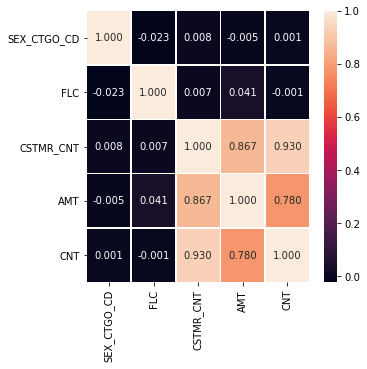

In [10]:
plt.figure(figsize=(5,5))
sns.heatmap(data = df.corr(), annot=True, 
fmt = '.3f', linewidths=.5)

분석 결과 CSTMR_CNT와 CNT를 제외한 변수들은 AMT와의 상관도가 낮다.

In [11]:
DF = df.copy() 
DF = DF.drop(['HOM_SIDO_NM','CARD_CCG_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD', 'FLC','CSTMR_CNT','CNT'], axis=1)

In [12]:
DF

REG_YYMM CARD_SIDO_NM STD_CLSS_NM      AMT
0       2019-01-01           강원  건강보조식품 소매업   311200
1       2019-01-01           강원  건강보조식품 소매업  1374500
2       2019-01-01           강원  건강보조식품 소매업   818700
3       2019-01-01           강원  건강보조식품 소매업  1717000
4       2019-01-01           강원  건강보조식품 소매업  1047300
...            ...          ...         ...      ...
1350317 2020-04-01           충북    휴양콘도 운영업    77000
1350318 2020-04-01           충북    휴양콘도 운영업    92000
1350319 2020-04-01           충북    휴양콘도 운영업   193000
1350320 2020-04-01           충북    휴양콘도 운영업    86000
1350321 2020-04-01           충북    휴양콘도 운영업   227000

[26048114 rows x 4 columns]

#### 4) 이상한 데이터 제거

In [13]:
DF[DF['AMT']<2000]

REG_YYMM CARD_SIDO_NM            STD_CLSS_NM   AMT
234726   2019-01-01           경기           기타 대형 종합 소매업   900
877390   2019-01-01           서울              내항 여객 운송업   500
1001180  2019-01-01           서울                수산물 소매업  1000
1423635  2019-01-01           전북     스포츠 및 레크레이션 용품 임대업    40
1423637  2019-01-01           전북     스포츠 및 레크레이션 용품 임대업    90
...             ...          ...                    ...   ...
24126444 2020-03-01           서울  피자 햄버거 샌드위치 및 유사 음식점업  1600
24593106 2020-03-01           제주              정기 항공 운송업   300
63288    2020-04-01           경기           기타 대형 종합 소매업  1230
780409   2020-04-01           서울           그외 기타 종합 소매업  1600
1185267  2020-04-01           전북            차량용 주유소 운영업    30

[94 rows x 4 columns]

In [14]:
idx = DF[DF['AMT']<2000].index
DF = DF.drop(idx)
DF

REG_YYMM CARD_SIDO_NM STD_CLSS_NM      AMT
0       2019-01-01           강원  건강보조식품 소매업   311200
1       2019-01-01           강원  건강보조식품 소매업  1374500
2       2019-01-01           강원  건강보조식품 소매업   818700
3       2019-01-01           강원  건강보조식품 소매업  1717000
4       2019-01-01           강원  건강보조식품 소매업  1047300
...            ...          ...         ...      ...
1350317 2020-04-01           충북    휴양콘도 운영업    77000
1350318 2020-04-01           충북    휴양콘도 운영업    92000
1350319 2020-04-01           충북    휴양콘도 운영업   193000
1350320 2020-04-01           충북    휴양콘도 운영업    86000
1350321 2020-04-01           충북    휴양콘도 운영업   227000

[26048014 rows x 4 columns]

40원, 90원등 작은 금액이 결제된 데이터들이 보여 2000원 미만으로 결제된 목록을 알아보았다.

이상치를 완전히 제거하기 위해 2000원 미만의 데이터들을 삭제하였다.

#### 6) 데이터 묶음

In [15]:
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM','REG_YYMM']
DF = DF.groupby(columns).sum().reset_index(drop=False)
DF

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM        AMT
0               강원  건강보조식품 소매업 2019-01-01  148354746
1               강원  건강보조식품 소매업 2019-02-01  146715871
2               강원  건강보조식품 소매업 2019-03-01  109439025
3               강원  건강보조식품 소매업 2019-04-01  106548473
4               강원  건강보조식품 소매업 2019-05-01  148115738
...            ...         ...        ...        ...
10043           충북    휴양콘도 운영업 2019-12-01  139568962
10044           충북    휴양콘도 운영업 2020-01-01  222073112
10045           충북    휴양콘도 운영업 2020-02-01   47085830
10046           충북    휴양콘도 운영업 2020-03-01   12733490
10047           충북    휴양콘도 운영업 2020-04-01    9328420

[10048 rows x 4 columns]

#### 7) 업종 별 결측값 확인

In [16]:
DF['STD_CLSS_NM'].value_counts()

차량용 주유소 운영업              272
과실 및 채소 소매업              272
슈퍼마켓                     272
화장품 및 방향제 소매업            272
차량용 가스 충전업               272
그외 기타 종합 소매업             272
기타 주점업                   272
중식 음식점업                  272
일반유흥 주점업                 272
여관업                      272
피자 햄버거 샌드위치 및 유사 음식점업    272
스포츠 및 레크레이션 용품 임대업       272
수산물 소매업                  272
비알콜 음료점업                 272
한식 음식점업                  272
기타 외국식 음식점업              272
체인화 편의점                  272
건강보조식품 소매업               272
일식 음식점업                  272
육류 소매업                   272
전시 및 행사 대행업              272
기타 대형 종합 소매업             272
기타음식료품위주종합소매업            272
서양식 음식점업                 272
골프장 운영업                  272
욕탕업                      272
빵 및 과자류 소매업              272
마사지업                     271
관광 민예품 및 선물용품 소매업        270
호텔업                      255
그외 기타 스포츠시설 운영업          253
자동차 임대업                  248
기타 수상오락 서비스업             227
여행사업                     215
택시 운송업        

2019년 1월부터 2020년 4월까지의 데이터가 모두 존재하면 272개 이다.

지역별로 없는 업종이 존재하는 걸로 보인다.

**(1) 마사지업**

In [17]:
DF_sample = pd.DataFrame(DF[DF['STD_CLSS_NM'] == '마사지업'])
DF_sample['CARD_SIDO_NM'].value_counts()

경북    16
울산    16
제주    16
전북    16
서울    16
부산    16
전남    16
충북    16
경기    16
충남    16
광주    16
대전    16
강원    16
인천    16
대구    16
경남    16
세종    15
Name: CARD_SIDO_NM, dtype: int64

In [18]:
DF_sample = DF_sample[DF_sample['CARD_SIDO_NM'] == '세종']
DF_sample

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM      AMT
5524           세종        마사지업 2019-01-01  3863800
5525           세종        마사지업 2019-02-01  4008000
5526           세종        마사지업 2019-03-01  5427000
5527           세종        마사지업 2019-04-01  4438000
5528           세종        마사지업 2019-05-01  6107000
5529           세종        마사지업 2019-06-01  6299000
5530           세종        마사지업 2019-07-01  4307000
5531           세종        마사지업 2019-08-01  1679000
5532           세종        마사지업 2019-09-01  2731000
5533           세종        마사지업 2019-10-01  5172000
5534           세종        마사지업 2019-11-01  4846750
5535           세종        마사지업 2019-12-01  3446000
5536           세종        마사지업 2020-01-01  5696000
5537           세종        마사지업 2020-02-01   583000
5538           세종        마사지업 2020-03-01  1371000

세종시에 마사지업 4월 데이터가 존재하지 않는다.

하지만, 분석에 영향을 줄 것 같지 않다.

**(2) 관광 민예품 및 선물용품 소매업**

In [32]:
DF_sample = pd.DataFrame(DF[DF['STD_CLSS_NM'] == '관광 민예품 및 선물용품 소매업'])
DF_sample['CARD_SIDO_NM'].value_counts()

경북    16
울산    16
제주    16
전북    16
서울    16
부산    16
전남    16
충북    16
경기    16
충남    16
광주    16
대전    16
강원    16
인천    16
대구    16
경남    16
세종    14
Name: CARD_SIDO_NM, dtype: int64

In [33]:
DF_sample = DF_sample[DF_sample['CARD_SIDO_NM'] == '세종']
DF_sample

CARD_SIDO_NM        STD_CLSS_NM   REG_YYMM      AMT
5427           세종  관광 민예품 및 선물용품 소매업 2019-01-01   198000
5428           세종  관광 민예품 및 선물용품 소매업 2019-02-01   128000
5429           세종  관광 민예품 및 선물용품 소매업 2019-03-01   661000
5430           세종  관광 민예품 및 선물용품 소매업 2019-04-01   323900
5431           세종  관광 민예품 및 선물용품 소매업 2019-05-01  1075400
5432           세종  관광 민예품 및 선물용품 소매업 2019-06-01  1126300
5433           세종  관광 민예품 및 선물용품 소매업 2019-07-01  1149400
5434           세종  관광 민예품 및 선물용품 소매업 2019-08-01  1286400
5435           세종  관광 민예품 및 선물용품 소매업 2019-09-01  1777900
5436           세종  관광 민예품 및 선물용품 소매업 2019-10-01   874900
5437           세종  관광 민예품 및 선물용품 소매업 2019-11-01   452300
5438           세종  관광 민예품 및 선물용품 소매업 2019-12-01   690700
5439           세종  관광 민예품 및 선물용품 소매업 2020-01-01   804700
5440           세종  관광 민예품 및 선물용품 소매업 2020-02-01    97000

세종시에 관광 3, 4월 데이터가 존재하지 않는다.

하지만, 분석에 영향을 줄 것 같지 않다.

**(3) 호텔업**

In [36]:
DF_sample = pd.DataFrame(DF[DF['STD_CLSS_NM'] == '호텔업'])
DF_sample['CARD_SIDO_NM'].value_counts()

경북    16
울산    16
대구    16
인천    16
강원    16
대전    16
광주    16
충남    16
경기    16
충북    16
전남    16
부산    16
서울    16
제주    16
경남    16
전북    15
Name: CARD_SIDO_NM, dtype: int64

In [37]:
DF_sample1 = DF_sample[DF_sample['CARD_SIDO_NM'] == '세종']
DF_sample1

Empty DataFrame
Columns: [CARD_SIDO_NM, STD_CLSS_NM, REG_YYMM, AMT]
Index: []

In [39]:
DF_sample2 = DF_sample[DF_sample['CARD_SIDO_NM'] == '전북']
DF_sample2

CARD_SIDO_NM STD_CLSS_NM   REG_YYMM       AMT
8181           전북         호텔업 2019-01-01   7573640
8182           전북         호텔업 2019-02-01  14207430
8183           전북         호텔업 2019-03-01   6368980
8184           전북         호텔업 2019-04-01   5350850
8185           전북         호텔업 2019-05-01   7379597
8186           전북         호텔업 2019-06-01   1425808
8187           전북         호텔업 2019-07-01    478000
8188           전북         호텔업 2019-08-01    941000
8189           전북         호텔업 2019-09-01   7485700
8190           전북         호텔업 2019-10-01   2300450
8191           전북         호텔업 2019-11-01   1807500
8192           전북         호텔업 2019-12-01    955600
8193           전북         호텔업 2020-01-01    835250
8194           전북         호텔업 2020-03-01    411200
8195           전북         호텔업 2020-04-01   1021700

전북 지역의 2월 데이터, 세종시 데이터가 존재하지 않는다.

**(4) 그외 기타 스포츠시설 운영업**

In [40]:
DF_sample = pd.DataFrame(DF[DF['STD_CLSS_NM'] == '그외 기타 스포츠시설 운영업'])
DF_sample['CARD_SIDO_NM'].value_counts()

경북    16
울산    16
전북    16
서울    16
부산    16
전남    16
충북    16
경기    16
충남    16
광주    16
대전    16
강원    16
인천    16
대구    16
경남    16
제주    12
세종     1
Name: CARD_SIDO_NM, dtype: int64

In [41]:
DF_sample1 = DF_sample[DF_sample['CARD_SIDO_NM'] == '제주']
DF_sample1

CARD_SIDO_NM      STD_CLSS_NM   REG_YYMM       AMT
8302           제주  그외 기타 스포츠시설 운영업 2019-01-01  15205500
8303           제주  그외 기타 스포츠시설 운영업 2019-02-01  17077500
8304           제주  그외 기타 스포츠시설 운영업 2019-03-01  10513000
8305           제주  그외 기타 스포츠시설 운영업 2019-04-01   7072100
8306           제주  그외 기타 스포츠시설 운영업 2019-05-01   7969700
8307           제주  그외 기타 스포츠시설 운영업 2019-06-01   6865400
8308           제주  그외 기타 스포츠시설 운영업 2019-07-01   1361800
8309           제주  그외 기타 스포츠시설 운영업 2019-08-01   5133949
8310           제주  그외 기타 스포츠시설 운영업 2019-09-01   1353700
8311           제주  그외 기타 스포츠시설 운영업 2019-10-01   1127800
8312           제주  그외 기타 스포츠시설 운영업 2019-11-01    849800
8313           제주  그외 기타 스포츠시설 운영업 2019-12-01    452900

In [42]:
DF_sample2 = DF_sample[DF_sample['CARD_SIDO_NM'] == '세종']
DF_sample2

CARD_SIDO_NM      STD_CLSS_NM   REG_YYMM     AMT
5442           세종  그외 기타 스포츠시설 운영업 2020-01-01  168000

제주시의 2020년 데이터, 세종시의 데이터들이 존재하지않는다.